# Custom PyTorch model in a `zea.Pipeline`

This example demonstrates how to embed a custom PyTorch model (defined in code) into a `zea.Pipeline` using a Lambda operation.  
We use the PICMUS ultrasound dataset, perform beamforming, and run a simple torch image processing model (blurring) on the resulting B-mode image.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/models/custom_models_example.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/models/custom_models_example.ipynb)

In [ ]:
%%capture
%pip install -U keras
%pip install zea

In [ ]:
# Set up environment for PyTorch
import os
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import torch
import torch.nn as nn
import numpy as np
import keras
import matplotlib.pyplot as plt
from IPython.display import display

import zea
from zea import load_file, init_device
from zea.visualize import set_mpl_style
from zea.ops import (
    Pipeline,
    PatchedGrid,
    EnvelopeDetect,
    Normalize,
    LogCompress,
    TOFCorrection,
    DelayAndSum,
    Lambda,
)

zea: Using backend 'torch'


In [3]:
device = init_device(verbose=False)
set_mpl_style()

## Load a Frame from the PICMUS Dataset

We use the zea loader to load a single frame of raw RF data from the PICMUS dataset, along with scan and probe parameters.

In [4]:
# Load a single frame of raw RF data from PICMUS
path = "hf://zeahub/picmus/database/experiments/contrast_speckle/contrast_speckle_expe_dataset_iq/contrast_speckle_expe_dataset_iq.hdf5"
data, scan, probe = load_file(
    path=path,
    indices=[0],
    data_type="raw_data",
)
scan.zlims = (0, 0.06)  # crop for visualization
scan.Nx = 300
scan.Nz = 500

dynamic_range = (-50, 0)

## Build a zea Pipeline for Beamforming and Image Formation

Let's build an example ultrasound image formation pipeline. We use a PatchedGrid pipeline for memory-efficient beamforming, followed by envelope detection, normalization, and log compression. Currently jit is not supported for backend set to "torch". If you really want to use jit (understandably so), you are best off using either "jax" or "tensorflow" as the backend.

In [5]:
pipeline = Pipeline(
    operations = [
        PatchedGrid(
            operations = [
                TOFCorrection(),
                DelayAndSum()
            ],
            num_patches = 100,
            jit_options = None,
        ),
        EnvelopeDetect(),
        Normalize(),
        LogCompress(),
    ],
    with_batch_dim = True,
    jit_options = None,
)

We prepare the parameters for the pipeline and run it to obtain a B-mode image.

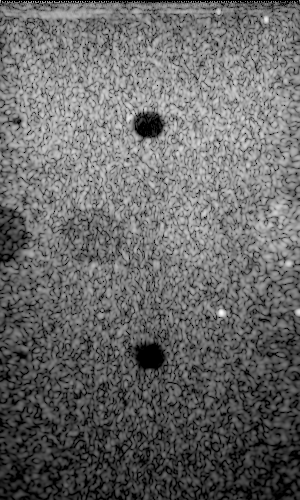

In [6]:
parameters = pipeline.prepare_parameters(probe, scan)
parameters["demodulation_frequency"] = parameters["sampling_frequency"]

inputs = {pipeline.key: keras.ops.convert_to_tensor(data)}
outputs = pipeline(**inputs, **parameters, dynamic_range=dynamic_range)
bmode = outputs[pipeline.output_key]

bmode_img = zea.display.to_8bit(bmode[0], dynamic_range=dynamic_range)
display(bmode_img)

## Embedding a custom PyTorch model

We define a simple torch model that applies a Gaussian blur using a convolutional layer with fixed weights.

In [7]:
class TorchGaussianBlur(nn.Module):
    def __init__(self, kernel_size=7, sigma=2.0):
        super().__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.padding = kernel_size // 2

        # Create Gaussian kernel
        ax = np.arange(-self.padding, self.padding + 1)
        xx, yy = np.meshgrid(ax, ax)
        kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
        kernel = kernel / np.sum(kernel)
        kernel = kernel.astype(np.float32)
        kernel = kernel[None, None, :, :]  # shape (1, 1, k, k)
        self.register_buffer("weight", torch.from_numpy(kernel))

    def forward(self, x):
        C = x.shape[1]
        weight = self.weight.repeat(C, 1, 1, 1)
        return torch.nn.functional.conv2d(x, weight, padding=self.padding, groups=C)

To embed this model in the zea pipeline, we use a Lambda operation that applies the model to the B-mode image. We first need to wrap the model call in a simple function that takes the image as input and returns the processed image.

In [8]:
torch_blur_model = TorchGaussianBlur(kernel_size=7, sigma=2.0)
torch_blur_model.eval()
torch_blur_model.to(device)

def torch_blur_inference(image):
    """Simple example inference function for the torch model."""
    image = image.to(torch_blur_model.weight.device)
    with torch.no_grad():
        image = torch.unsqueeze(image, axis=-1)
        out = torch_blur_model(image)
        out = torch.squeeze(out, axis=-1)
    return out

## Add a Lambda Operation to an existing Pipeline

We add a Lambda operation to the pipeline to run the torch blurring model on the B-mode image.

In [9]:
blurring_pipeline = Pipeline(
    operations=[
        pipeline,
        Lambda(
            func=torch_blur_inference,
            key=pipeline.output_key,
            output_key="blurred"
        )
    ],
    with_batch_dim=True,
    jit_options=None,
)

Run the pipeline and visualize the blurred image.

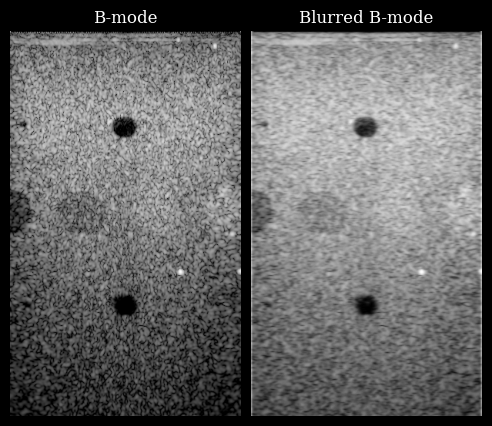

In [10]:
result = blurring_pipeline(**inputs, **parameters)
blurred = result["blurred"]

blurred = zea.display.to_8bit(
    blurred[0],
    dynamic_range=dynamic_range,
    pillow=False,
)
bmode_img = zea.display.to_8bit(
    bmode[0],
    dynamic_range=dynamic_range,
    pillow=False,
)

fig, _ = zea.visualize.plot_image_grid(
    [bmode_img, blurred],
    titles=["B-mode", "Blurred B-mode"],
    cmap="gray",
    figsize=(10, 5),
)